
# Eunomia → Hypergraph Prep Notebook

This notebook:
1. Loads **Eunomia OMOP CDM** tables from CSVs.  
2. Builds a **hypergraph view**:
   - Nodes = clinical concepts (Dx, Rx, Px)
   - Hyperedges = visits (person × visit_occurrence)  
   - Incidence list = which concepts appear in which visit
3. Computes **basic statistics** and **visualisations**:
   - Visits per patient  
   - Concepts per visit (hyperedge size)  
   - Concept degrees (how many visits each concept appears in)



In [3]:

# 0. Imports and basic config

import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)

# === CONFIG: change this to where your Eunomia CSVs live ===
BASE_DIR = Path("Baselines/data/eunomia")  # e.g. data/eunomia_csv
OUT_DIR = Path("Baselines/data/eunomia_hypergraph")  # where processed artifacts will go
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Input CSV folder:", BASE_DIR.resolve())
print("Output folder:", OUT_DIR.resolve())


Input CSV folder: D:\17627\佘雨亭\NUS\MA4198\HypKG\Baselines\data\eunomia
Output folder: D:\17627\佘雨亭\NUS\MA4198\HypKG\Baselines\data\eunomia_hypergraph


In [6]:
condition = pd.read_csv(BASE_DIR / "condition_occurrence.csv")
condition.columns = [c.lower() for c in condition.columns]

#print(condition.head())
#print("Number of rows:", len(condition))

# Look at the most common condition_concept_ids
print(condition["condition_concept_id"].value_counts().head(20))

condition_concept_id
40481087    17268
4112343     10217
260139       8184
372328       3605
80180        2694
28060        2656
81151        1915
378001       1013
4283893      1001
4294548       939
4218389       825
257012        825
4027663       802
78272         770
4278672       569
4155034       507
4113008       500
4152936       499
4156265       497
4134304       493
Name: count, dtype: int64



## 1. Load Eunomia CSVs

We expect the following OMOP CDM tables in `BASE_DIR`:

- `person.csv`  
- `visit_occurrence.csv`  
- `condition_occurrence.csv`  
- `drug_exposure.csv`  
- `procedure_occurrence.csv`  
- `concept.csv`


In [5]:

# 1. Load core OMOP tables from CSV

def load_omop_from_csv(base: Path):
    person = pd.read_csv(base / "person.csv")
    visit = pd.read_csv(base / "visit_occurrence.csv")
    condition = pd.read_csv(base / "condition_occurrence.csv")
    drug = pd.read_csv(base / "drug_exposure.csv")
    procedure = pd.read_csv(base / "procedure_occurrence.csv")
    concept = pd.read_csv(base / "concept.csv")
    return person, visit, condition, drug, procedure, concept

person, visit, condition, drug, procedure, concept = load_omop_from_csv(BASE_DIR)

# Normalize all column names to lowercase so we can use OMOP names in lowercase
for df in [person, visit, condition, drug, procedure, concept]:
    df.columns = [c.lower() for c in df.columns]

print("person:", person.shape)
print("visit_occurrence:", visit.shape)
print("condition_occurrence:", condition.shape)
print("drug_exposure:", drug.shape)
print("procedure_occurrence:", procedure.shape)
print("concept:", concept.shape)


person: (2694, 18)
visit_occurrence: (1037, 17)
condition_occurrence: (65332, 16)
drug_exposure: (67707, 23)
procedure_occurrence: (37409, 14)
concept: (444, 10)



## 2. Basic patient and visit statistics


Number of persons: 2694
Number of visits: 1037
Visits per person:
count    890.000000
mean       1.165169
std        0.414474
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: visit_occurrence_id, dtype: float64


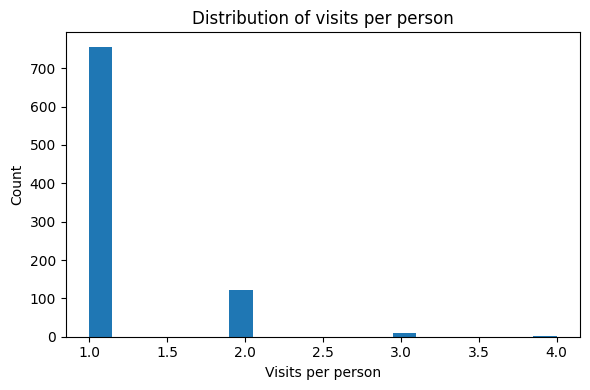

In [6]:

# 2. Basic stats: visits per person

visits_per_person = visit.groupby("person_id")["visit_occurrence_id"].nunique()

print("Number of persons:", person["person_id"].nunique())
print("Number of visits:", visit["visit_occurrence_id"].nunique())
print("Visits per person:")
print(visits_per_person.describe())

plt.figure()
plt.hist(visits_per_person.values, bins=20)
plt.xlabel("Visits per person")
plt.ylabel("Count")
plt.title("Distribution of visits per person")
plt.tight_layout()
plt.show()



## 3. Build hyperedges (visits) and concept nodes

- We treat **each visit** (`visit_occurrence_id`) as a **hyperedge**.  
- Nodes are **clinical concepts** from:
  - `condition_occurrence.condition_concept_id` (Dx)  
  - `drug_exposure.drug_concept_id` (Rx)  
  - `procedure_occurrence.procedure_concept_id` (Px)


In [7]:

# 3.1 Create hyperedge table: one row per visit

hyperedges = visit[["visit_occurrence_id", "person_id", "visit_start_date"]].copy()
hyperedges = hyperedges.sort_values(["person_id", "visit_start_date", "visit_occurrence_id"]).reset_index(drop=True)
hyperedges["hyperedge_id"] = np.arange(len(hyperedges), dtype=int)

hyperedges = hyperedges[["hyperedge_id", "person_id", "visit_occurrence_id", "visit_start_date"]]
hyperedges.head()


,hyperedge_id,person_id,visit_occurrence_id,visit_start_date
0,0,1,85,1981-08-18
1,1,2,148,2008-03-15
2,2,3,311,1958-01-29
3,3,3,312,1972-12-20
4,4,5,468,1990-04-07


In [8]:

# 3.2 Create concept node table: Dx, Rx, Px

dx_nodes = condition[["condition_concept_id"]].rename(columns={"condition_concept_id": "concept_id"})
dx_nodes["type"] = "Dx"

rx_nodes = drug[["drug_concept_id"]].rename(columns={"drug_concept_id": "concept_id"})
rx_nodes["type"] = "Rx"

px_nodes = procedure[["procedure_concept_id"]].rename(columns={"procedure_concept_id": "concept_id"})
px_nodes["type"] = "Px"

nodes = pd.concat([dx_nodes, rx_nodes, px_nodes], ignore_index=True)
nodes = nodes[nodes["concept_id"] > 0].drop_duplicates().reset_index(drop=True)

print("Number of unique concept nodes:", len(nodes))
nodes.head()


Number of unique concept nodes: 244


,concept_id,type
0,4112343,Dx
1,192671,Dx
2,28060,Dx
3,378001,Dx
4,257012,Dx



## 4. Build incidence list (which concepts appear in which visit)

We build a long table `incidence` with columns:

- `hyperedge_id`  
- `concept_id`  

Each row says “concept appears in this visit hyperedge”.


In [9]:

# 4. Build incidence from condition, drug, and procedure tables

he_key = hyperedges[["hyperedge_id", "visit_occurrence_id"]].copy()

dx = condition[["visit_occurrence_id", "condition_concept_id"]].rename(
    columns={"condition_concept_id": "concept_id"}
)
rx = drug[["visit_occurrence_id", "drug_concept_id"]].rename(
    columns={"drug_concept_id": "concept_id"}
)
px = procedure[["visit_occurrence_id", "procedure_concept_id"]].rename(
    columns={"procedure_concept_id": "concept_id"}
)

all_inc = pd.concat([dx, rx, px], ignore_index=True)
all_inc = all_inc[all_inc["concept_id"] > 0].dropna().drop_duplicates()

incidence = he_key.merge(all_inc, on="visit_occurrence_id", how="left").dropna()
incidence = incidence[["hyperedge_id", "concept_id"]].drop_duplicates().reset_index(drop=True)

print("Incidence rows:", incidence.shape[0])
incidence.head()


Incidence rows: 1285


,hyperedge_id,concept_id
0,0,80180
1,0,4285898
2,0,1118084
3,0,44783196
4,1,255848



## 5. Hypergraph statistics and visualisations

We examine:

- **Hyperedge size** distribution: number of concepts per visit.  
- **Concept degree** distribution: in how many visits each concept appears.


In [7]:

# 5.1 Hyperedge size distribution (concepts per visit)

he_sizes = incidence.groupby("hyperedge_id")["concept_id"].nunique()

print("Hyperedge size (concepts per visit):")
print(he_sizes.describe())

plt.figure()
plt.hist(he_sizes.values, bins=30)
plt.xlabel("Number of concepts in visit (hyperedge size)")
plt.ylabel("Count")
plt.title("Distribution of hyperedge sizes")
plt.tight_layout()
plt.show()


NameError: name 'incidence' is not defined

Concept degrees (visits per concept):
count     32.000000
mean      40.156250
std       96.822455
min        1.000000
25%        3.000000
50%        4.000000
75%       22.500000
max      479.000000
Name: hyperedge_id, dtype: float64


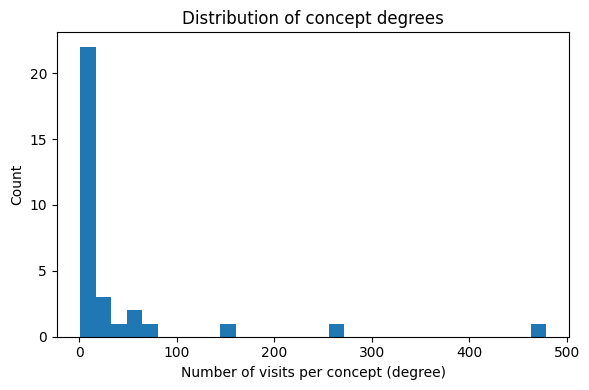

In [ ]:

# 5.2 Concept degree distribution (visits per concept)

concept_degrees = incidence.groupby("concept_id")["hyperedge_id"].nunique()

print("Concept degrees (visits per concept):")
print(concept_degrees.describe())

plt.figure()
plt.hist(concept_degrees.values, bins=30)
plt.xlabel("Number of visits per concept (degree)")
plt.ylabel("Count")
plt.title("Distribution of concept degrees")
plt.tight_layout()
plt.show()



## 6. Inspect a small sample of the hypergraph

We just peek at a small subset of hyperedges and their concepts, to sanity-check the structure.


In [ ]:

# 6. Sample a few hyperedges and their concepts

sample_hes = hyperedges.sample(n=min(5, len(hyperedges)), random_state=0)["hyperedge_id"].tolist()
sample_inc = incidence[incidence["hyperedge_id"].isin(sample_hes)].copy()
sample_inc = sample_inc.merge(nodes, on="concept_id", how="left")
sample_inc = sample_inc.sort_values(["hyperedge_id", "type", "concept_id"])

sample_inc.head(20)


,hyperedge_id,concept_id,type
0,75,192671,Dx
1,97,44783196,Px
3,249,44783196,Px
2,249,40162522,Rx
5,597,44783196,Px
4,597,40231925,Rx
6,822,192671,Dx



## 7. Save processed artifacts for downstream models / visualisations

We save:

- `nodes.csv`  
- `hyperedges.csv`  
- `incidence.csv`  

These can be used directly for HypKG-style training or embedding visualisation notebooks.


In [ ]:

# 7. Save to OUT_DIR

nodes.to_csv(OUT_DIR / "nodes.csv", index=False)
hyperedges.to_csv(OUT_DIR / "hyperedges.csv", index=False)
incidence.to_csv(OUT_DIR / "incidence.csv", index=False)

print("Saved:")
print("  ", OUT_DIR / "nodes.csv")
print("  ", OUT_DIR / "hyperedges.csv")
print("  ", OUT_DIR / "incidence.csv")


Saved:
   Baselines\data\eunomia_hypergraph\nodes.csv
   Baselines\data\eunomia_hypergraph\hyperedges.csv
   Baselines\data\eunomia_hypergraph\incidence.csv


In [ ]:
nodes = pd.read_csv("./Baselines/data/eunomia_hypergraph/nodes.csv")
labels = pd.read_csv("./Contextualization/data/raw_data/eunomia/edge-labels-eunomia.txt", header=None)
print(len(nodes), labels.shape[1])


244 1


In [8]:
labels = pd.read_csv("./Contextualization/data/raw_data/eunomia/edge-labels-eunomia.txt", header=None)
print("Labels shape:", labels.shape)
print("Number of positives:", int(labels.values.sum()))
print("Number of negatives:", labels.size - int(labels.values.sum()))


Labels shape: (1037, 1)
Number of positives: 0
Number of negatives: 1037
